In [379]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import griddata
import sklearn.cluster as cluster
%matplotlib inline

In [316]:
trj1 = np.loadtxt('data/trj1.txt')
trj2 = np.loadtxt('data/trj2.txt')

* mass - kg
* coordinates - m
* potential energy - J

In [319]:
print(min(trj1[:,0]))

-1.0


In [218]:
trj1 = trj1[:10000]
trj2 = trj2[:10000]

### a) Plot trajectory and color  by time step:

In [300]:
def plot_trajectory(traj):
    plt.figure(figsize=(9,7))
    plt.scatter(traj[:,0], traj[:,1], s=2, c=np.arange(len(traj[:,0])))
    plt.title('Positions colored by time step')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
    plt.axis('equal')

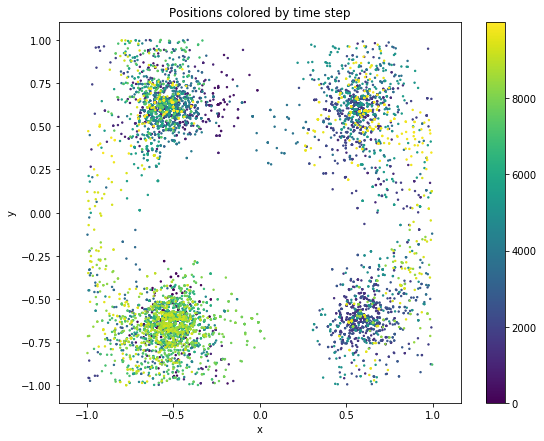

In [301]:
plot_trajectory(trj1)

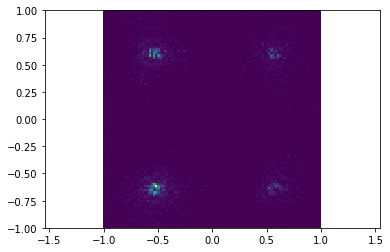

In [303]:
plt.hist2d(trj1[:,0], trj1[:,1], bins=100)
plt.axis('equal')
plt.show()

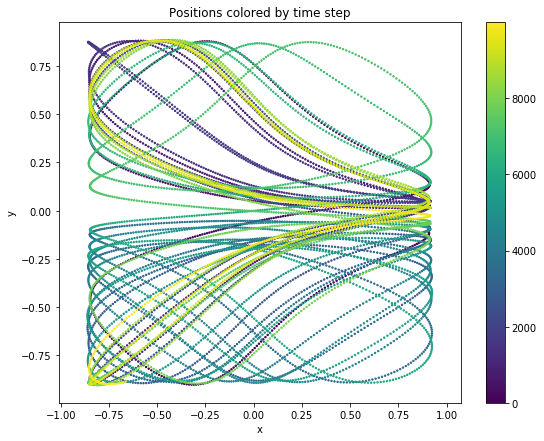

In [6]:
plot_trajectory(trj2)

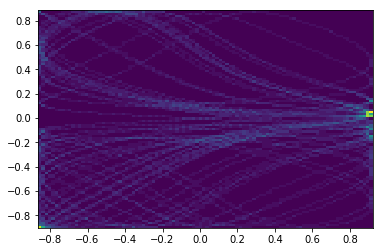

In [260]:
plt.hist2d(trj2[:,0], trj2[:,1], bins=100)
plt.show()

### b) Discretize position and plot potential as function of position:

* coordinates are from -1m to 1m --> 2m
* discretize by 0.1m --> 20x20 grid

In [126]:
def plot_potential(traj):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('Potential field')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('V(x, y)')

    dat = ax.scatter(traj[:,0], traj[:,1], traj[:,2], c=traj[:,2], cmap=cm.coolwarm)
    fig.colorbar(dat, orientation='horizontal')

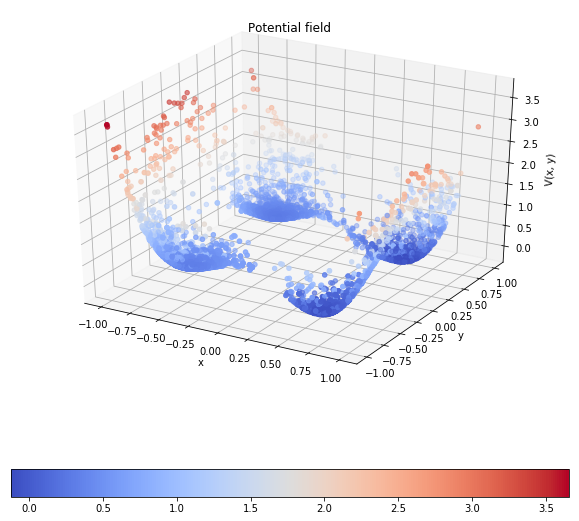

In [253]:
plot_potential(trj1)

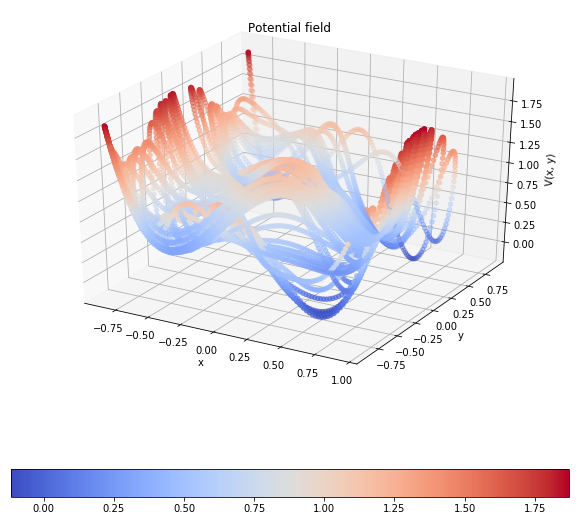

In [10]:
plot_potential(trj2)

In [330]:
def discretize_grid(traj):
    
    x = np.arange(min(traj[:,0])+0.1,  max(traj[:,0]), 0.1)
    y = np.arange(min(traj[:,1])+0.1,  max(traj[:,1]), 0.1)
    z = traj[:,2]
    X, Y = np.meshgrid(x, y)
    zi = griddata((traj[:,0], traj[:,1]), z, (X, Y), method='cubic')

    for i in range(len(zi)):
        zi[i] = [0 if np.isnan(j) else j for j in zi[i]]

    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, zi, cmap=cm.coolwarm)
    
    fig, ax = plt.subplots()
    p = ax.pcolor(X, Y, zi, cmap=cm.coolwarm)
    cb = fig.colorbar(p)
    return zi

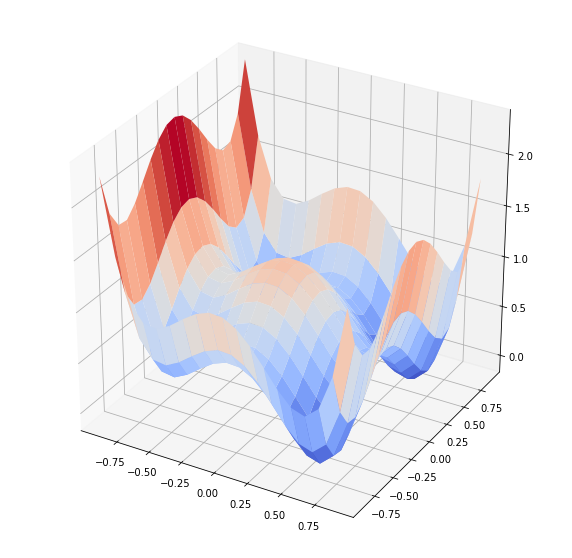

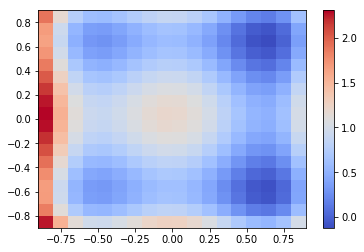

In [331]:
pot1 = discretize_grid(trj1)

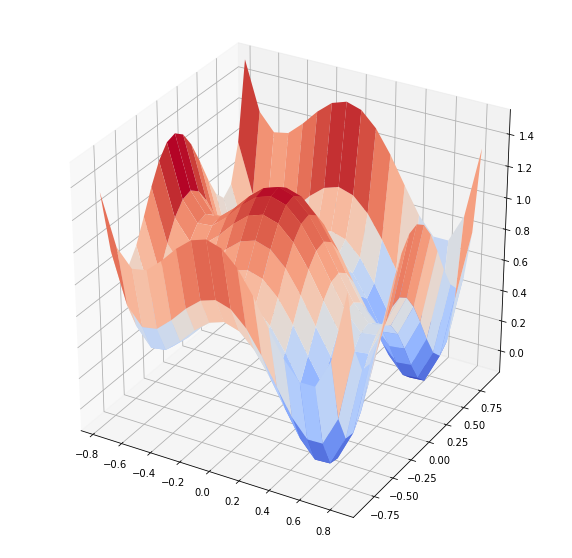

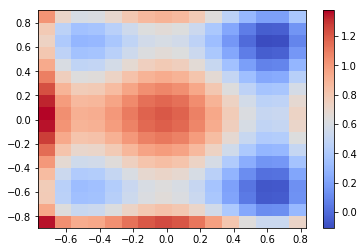

In [355]:
pot2 = discretize_grid(trj2)

### c) Compute position probability and relative free energy:

because unknown temperatue use Bolztman distribnution????

In [356]:
def position_probability(pot):
    pot_ = pot.reshape(-1)
    probability = []
    for i in range(len(pot_)):
        pr = np.exp(-pot_)/np.exp(np.sum(-pot_))
        probability.append(pr)
    return pot_.reshape(pot.shape)

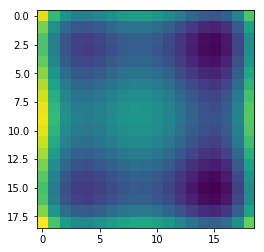

In [360]:
prob1 = position_probability(pot1)
plt.imshow(prob1)

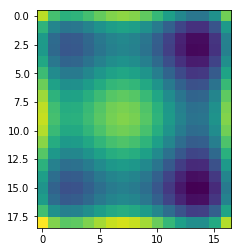

In [361]:
prob2 = position_probability(pot2)
plt.imshow(prob2)

### d) Cluster trajectory

In [382]:
def plot_clusters(traj, kmeans):
    clusters = kmeans.labels_
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.scatter(traj[:,0], traj[:,1], c=clusters, s=1)

    centers = np.array([np.mean(traj[:,:2][np.where(clusters == i)], axis=0) for i in range(4)])
    ax.scatter(centers[:,0], centers[:,1],  marker='*', s=100, linewidths=2, c='black')

    ax.set_title('Position clusters')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

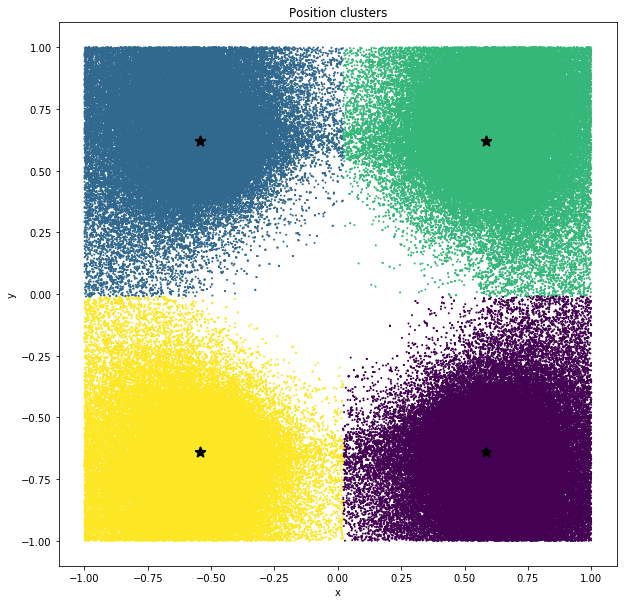

In [383]:
kmeans1 = cluster.KMeans(n_clusters=4).fit(trj1[:,:2])
plot_clusters(trj1, kmeans1)

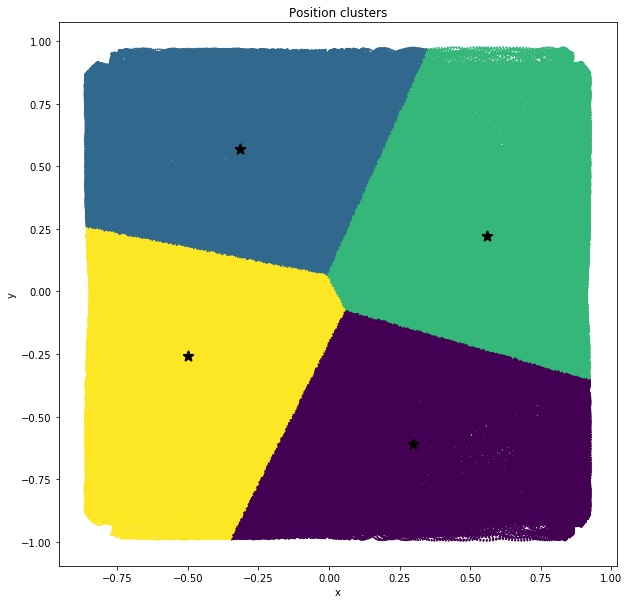

In [384]:
kmeans2 = cluster.KMeans(n_clusters=4).fit(trj2[:,:2])
plot_clusters(trj2, kmeans2)

### e) Probabilities of the clusters

In [427]:
def cluster_probability(kmeans):
    clusters = kmeans.labels_
    print(len(np.where(clusters == 0)[0])/len(clusters))
    print(len(np.where(clusters == 1)[0])/len(clusters))
    print(len(np.where(clusters == 2)[0])/len(clusters))
    print(len(np.where(clusters == 3)[0])/len(clusters))

In [428]:
cluster_probability(kmeans1)

0.253509
0.251412
0.255673
0.239406


In [429]:
cluster_probability(kmeans2)

0.20128
0.244223
0.266445
0.288052


### g) Transition matrix and Markov state model

In [444]:
def transition_matrix(x):
    n = len(np.unique(x))
    P = np.zeros((n, n))
    for i in range(len(x)-1):
        P[x[i], x[i+1]] = P[x[i], x[i+1]] + 1
    for i in range(4):
        P[i, :] = P[i, :]/np.sum(P[i, :])
    return P

In [446]:
P_t = transition_matrix(kmeans1.labels_)
print(np.around(P_t, 3))

[[0.983 0.    0.012 0.005]
 [0.    0.984 0.005 0.01 ]
 [0.011 0.005 0.983 0.   ]
 [0.005 0.011 0.    0.984]]


In [447]:
P_t = transition_matrix(kmeans2.labels_)
print(np.around(P_t, 3))

[[0.988 0.    0.005 0.007]
 [0.    0.99  0.006 0.005]
 [0.004 0.005 0.99  0.001]
 [0.005 0.004 0.001 0.99 ]]
